# FAI Final project

### Install and import required libraries

In [ ]:
# prompt: mount google drive to colab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=64e843a92afafaea0c8ffb60a5e03a7330db3e3a484ea80f4f4ad8ad51ecc255
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import ta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import warnings
warnings.filterwarnings("ignore")

### Data Loading

The historical stock price data for companies included in the Dow Jones Industrial Average (DJIA) index is the dataset utilized in this analysis. Although the DJIA normally consists of 30 well-known stocks, we have concentrated on a selection of 20 stocks that have been and still are parts of the index since 2010.

The dataset contains adjusted close prices, trading volumes, and daily stock price information, including opening, closing, highest, and lowest values. More than ten years of data, from January 1, 2010, to the present, are available for analysis.

This dataset, which comes from the reliable financial data platform Yahoo Finance API, is useful for both analysts and investors. It offers perceptions into industry and sector-specific market trends as well as the performance of specific companies.

The Relative Strength Index (RSI) and other computed metric Log Returns are also included in the dataset, which increases its usefulness for modeling and technical analysis. These measurements allow for more thorough analysis and interpretation as well as deeper insights.

In [ ]:
# Start and end dates for historical data
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime.now()

# Define a list of stock tickers representing companies in the DJIA index
# These tickers are chosen to represent a diverse set of industries within the index
# These symbols will be used to fetch historical stock price data for analysis and visualization.
dji_stocks = [
    'AXP',  # American Express Company
    'BA',   # The Boeing Company
    'CAT',  # Caterpillar Inc.
    'CSCO', # Cisco Systems, Inc.
    'CVX',  # Chevron Corporation
    'DIS',  # The Walt Disney Company
    'HD',   # The Home Depot, Inc.
    'IBM',  # International Business Machines Corporation
    'INTC', # Intel Corporation
    'JNJ',  # Johnson & Johnson
    'JPM',  # JPMorgan Chase & Co.
    'KO',   # The Coca-Cola Company
    'MCD',  # McDonald's Corporation
    'MMM',  # 3M Company
    'MRK',  # Merck & Co., Inc.
    'MSFT', # Microsoft Corporation
    'PG',   # Procter & Gamble Company
    'TRV',  # The Travelers Companies, Inc.
    'VZ',   # Verizon Communications Inc.
    'WMT'   # Walmart Inc.
]

# Fetch historical data for each stock and create a DataFrame
for stock in dji_stocks:
    # Fetch data from Yahoo Finance API
    data = yf.download(stock, start=start_date, end=end_date)

    # Create a DataFrame with the stock symbol as the variable name
    # This assigns the DataFrame to a variable with the stock symbol as its name
    globals()[stock] = data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
MSFT.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,30.620001,31.100000,30.590000,30.950001,23.431587,38409100
2010-01-05,30.850000,31.100000,30.639999,30.959999,23.439154,49749600
2010-01-06,30.879999,31.080000,30.520000,30.770000,23.295317,58182400
2010-01-07,30.629999,30.700001,30.190001,30.450001,23.053047,50559700
2010-01-08,30.280001,30.879999,30.240000,30.660000,23.212032,51197400


### Data Exploration

#### Check for missing values

In [ ]:
# Check for null values for each stock
for stock in dji_stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]

    # Check for null values
    if df.isnull().values.any():
        print(f"\nMissing values found for {stock}.")
        print("Columns with missing values:")
        print(df.columns[df.isnull().any()])

#### Visualization for daily trends in adjusted close price of each stock

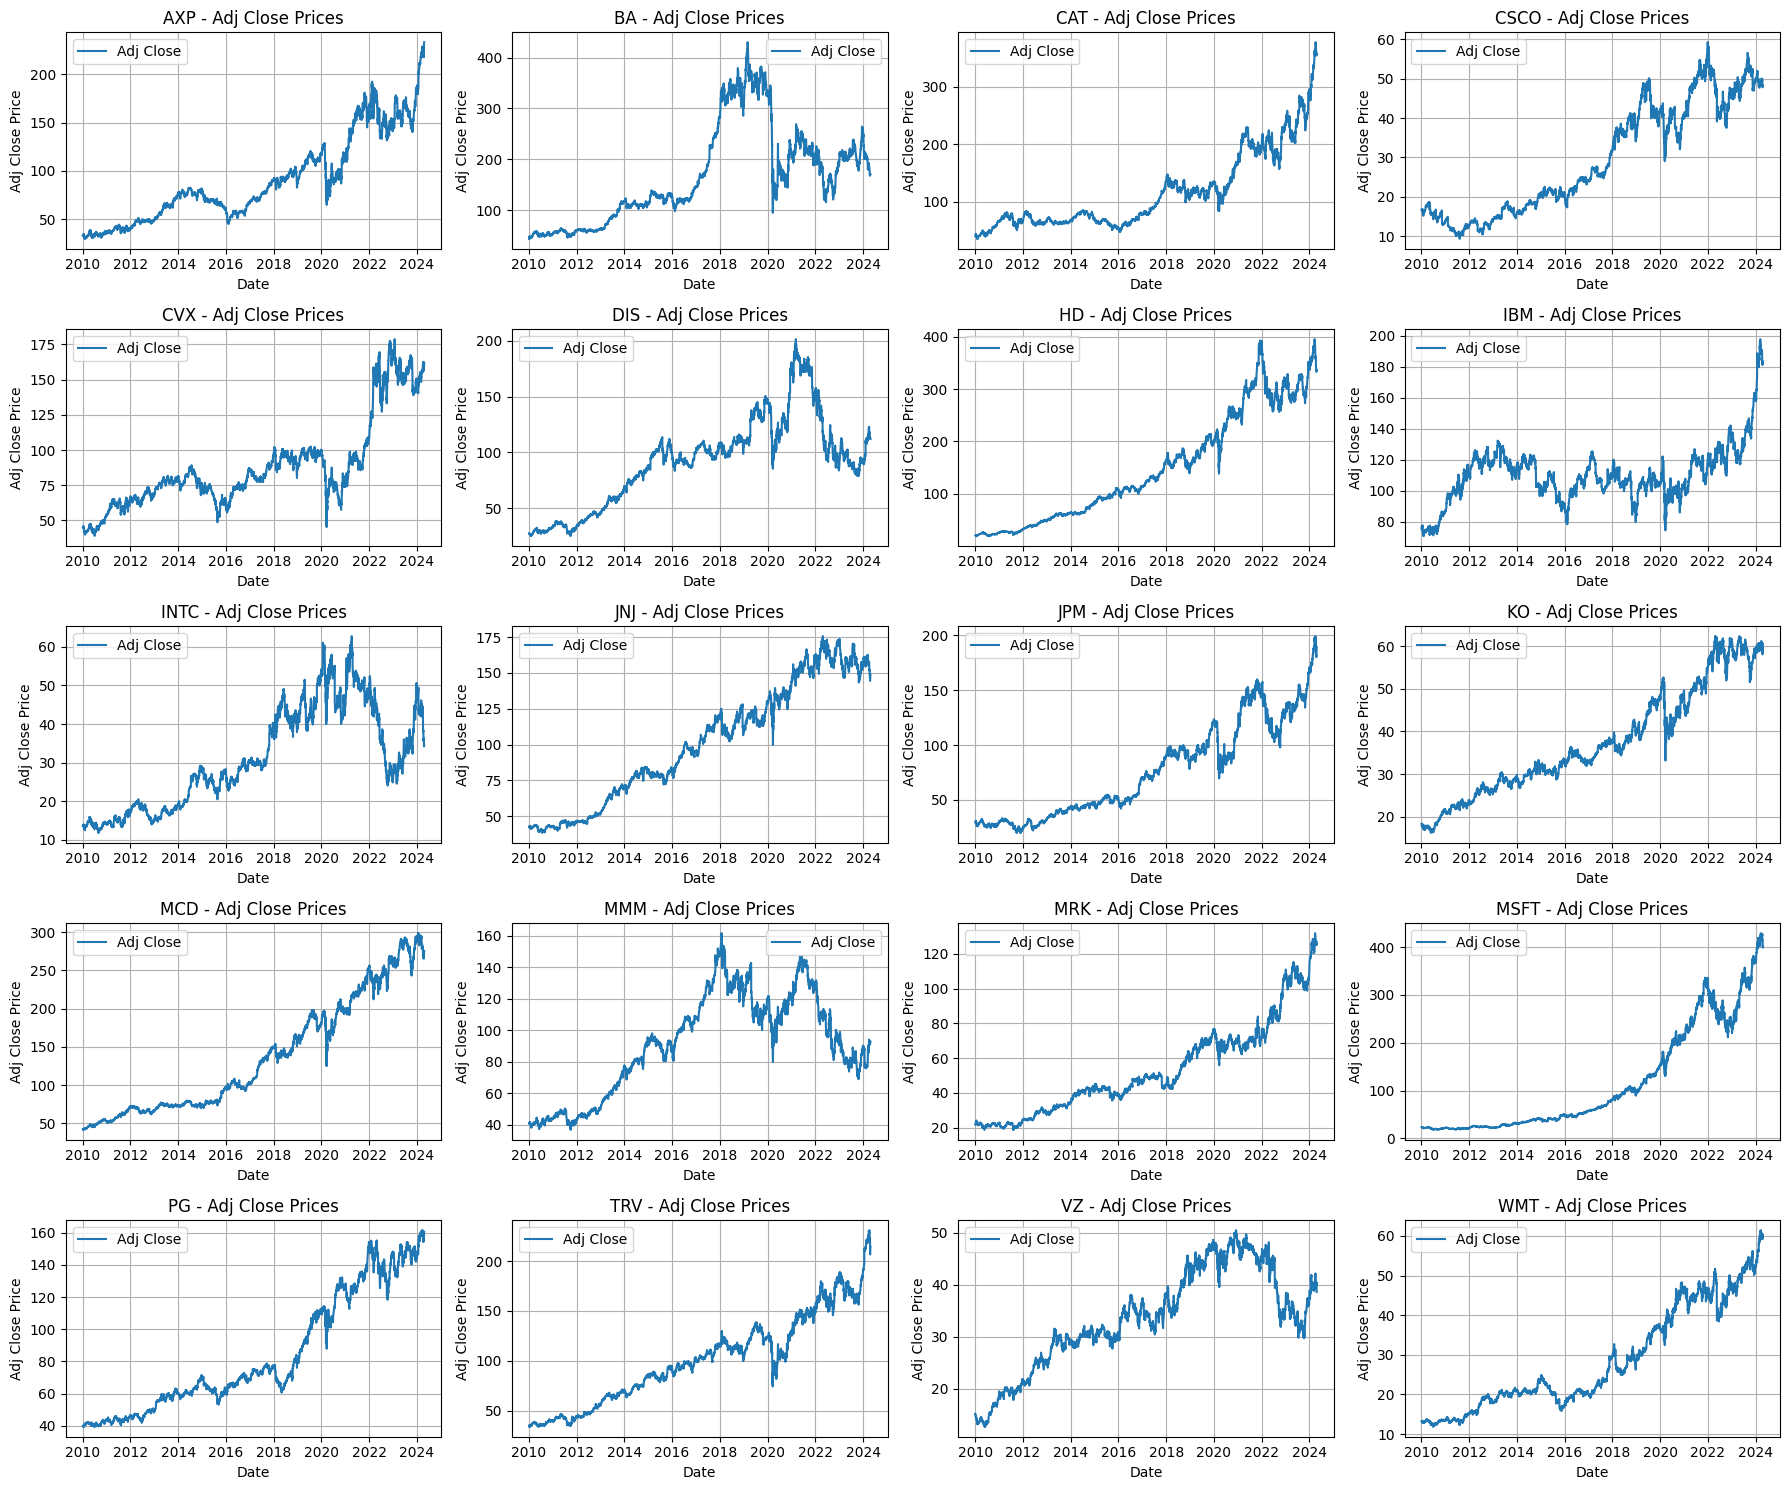

In [ ]:
# Define the number of rows and columns for the subplot grid
num_rows, num_cols = 5, 4

# Create a figure and axis objects for the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 15))

# Plot time series visualization for each stock
for ax, stock in zip(axs.flatten(), dji_stocks):
    df = globals()[stock]  # Access the DataFrame for the current stock
    ax.plot(df.index, df['Adj Close'], label='Adj Close')
    ax.set(title=f'{stock} - Adj Close Prices', xlabel='Date', ylabel='Adj Close Price')
    ax.grid(True)
    ax.legend()

# Hide any unused subplots and adjust layout
for ax in axs.flatten()[len(dji_stocks):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Data Preparation and Preprocessing

#### Calculating RSI

In [ ]:
# Calculate RSI for each stock
for stock in dji_stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]

    # Calculate RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Adj Close'], window=14).rsi()

#### Calculating Log Returns

In [ ]:
# Calculate log returns for each stock
for stock in dji_stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]

    # Calculate log returns and create a new column
    df['Log Returns'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))

In [ ]:
for stock in dji_stocks:
  df = globals()[stock]
  df.dropna(inplace=True)


Ensuring that data is stationary, as ARIMA models are sensitive to the trend and seasonality.

In [ ]:
for stock in dji_stocks:
  df = globals()[stock]

  # Convert the index to datetime
  df.index = pd.to_datetime(df.index)

  # Split the data into training and test sets based on the date
  train_data = df['Log Returns'][df.index < '2024-01-01']
  test_data = df['Log Returns'][df.index >= '2024-01-01']

  # Check for stationarity
  adf_result = adfuller(train_data.dropna())  # Using dropna() to remove NaN values
  print("For stock", stock)
  print(f'ADF Statistic: {adf_result[0]}')
  print(f'p-value: {adf_result[1]}')
  print()

For stock AXP
ADF Statistic: -12.250990239832397
p-value: 9.541552209110356e-23

For stock BA
ADF Statistic: -13.690268695721969
p-value: 1.348095406625974e-25

For stock CAT
ADF Statistic: -19.23020785888024
p-value: 0.0

For stock CSCO
ADF Statistic: -21.4976655186313
p-value: 0.0

For stock CVX
ADF Statistic: -13.168881613563117
p-value: 1.2623522603821854e-24

For stock DIS
ADF Statistic: -16.96080243423652
p-value: 9.311620801751432e-30

For stock HD
ADF Statistic: -20.387579055875495
p-value: 0.0

For stock IBM
ADF Statistic: -14.056931716302078
p-value: 3.1052954699292227e-26

For stock INTC
ADF Statistic: -16.603756863196942
p-value: 1.7552089314220134e-29

For stock JNJ
ADF Statistic: -15.451632444274907
p-value: 2.779274036234694e-28

For stock JPM
ADF Statistic: -11.749487105282832
p-value: 1.2188109069944346e-21

For stock KO
ADF Statistic: -18.322845241283787
p-value: 2.2639886909305906e-30

For stock MCD
ADF Statistic: -12.117292351173084
p-value: 1.8597432853092874e-22



Since the p-value is 0.0, which is less than the common threshold of 0.05, you can reject the null hypothesis and conclude that the time series is stationary.

### Rolling ARIMA

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from concurrent.futures import ProcessPoolExecutor

window_size = 50  # Use 50 past observations to predict the next one

def train_model(stock):
    print(f'Starting training for {stock}\n')
    df = globals()[stock]  # Assuming each stock's data is loaded in the global namespace
    predictions = []
    actual = []

    # ARIMA model with fixed parameters
    for end in range(window_size, len(df['Log Returns'])):
        train = df['Log Returns'][(end - window_size):end]
        model = ARIMA(train, order=(1, 0, 1))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1).iloc[0]
        predictions.append(pred)
        actual.append(df['Log Returns'].iloc[end])

    # Save predictions to .txt file
    with open(f'/content/drive/MyDrive/{stock}_predictions.txt', 'w') as txt_file:
        txt_file.write('\n'.join(map(str, predictions)))

    # Compute Mean Squared Error
    mse = np.mean((np.array(actual) - np.array(predictions))**2)

    # Collect results
    result = {
        'stock': stock,
        'mse': mse,
        'model_summary': model_fit.summary()
    }

    print(f'Finished training for {stock}')
    return result

# List of stocks
stocks = ['MSFT', 'AXP', 'BA', 'CAT', 'CSCO']

# Use ProcessPoolExecutor to execute the training in parallel
if __name__ == '__main__':
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(train_model, stocks))

    # Process and print results for each stock
    for result in results:
        print(f'MSE for {result["stock"]}: {result["mse"]}\n')
        print(f'Model Summary for {result["stock"]}:\n{result["model_summary"]}\n')


Starting training for MSFT

Starting training for AXP



In [ ]:
# List of stocks
stocks = ['CVX', 'DIS', 'HD', 'IBM', 'INTC', 'JNJ']

# Use ProcessPoolExecutor to execute the training in parallel
if __name__ == '__main__':
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(train_model, stocks))

    # Process and print results for each stock
    for result in results:
        print(f'MSE for {result["stock"]}: {result["mse"]}\n')
        print(f'Model Summary for {result["stock"]}:\n{result["model_summary"]}\n')


In [ ]:
stocks = ['JPM',  # JPMorgan Chase & Co.
    'KO',   # The Coca-Cola Company
    'MCD',  # McDonald's Corporation
    'MMM',  # 3M Company
    'MRK']  # Merck & Co., Inc.

# Use ProcessPoolExecutor to execute the training in parallel
if __name__ == '__main__':
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(train_model, stocks))

    # Process and print results for each stock
    for result in results:
        print(f'MSE for {result["stock"]}: {result["mse"]}\n')
        print(f'Model Summary for {result["stock"]}:\n{result["model_summary"]}\n')


In [ ]:
stocks = ['PG',   # Procter & Gamble Company
    'TRV',  # The Travelers Companies, Inc.
    'VZ',   # Verizon Communications Inc.
    'WMT']   # Walmart Inc.

# Use ProcessPoolExecutor to execute the training in parallel
if __name__ == '__main__':
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(train_model, stocks))

    # Process and print results for each stock
    for result in results:
        print(f'MSE for {result["stock"]}: {result["mse"]}\n')
        print(f'Model Summary for {result["stock"]}:\n{result["model_summary"]}\n')

### Rolling Window - LSTM

In [ ]:
!pip install keras_tuner

In [ ]:
from keras_tuner import RandomSearch, HyperParameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf

In [ ]:
def tune_model(stock, df):
    print(f'Starting hyperparameter tuning for {stock}')
    feature_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'RSI']
    target_col = ['Log Returns']
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler_features.fit_transform(df[feature_cols].dropna())
    scaled_target = scaler_target.fit_transform(df[target_col].dropna())

    X, y = [], []
    for i in range(50, len(scaled_features)):
        X.append(scaled_features[i - 50:i])
        y.append(scaled_target[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], len(feature_cols))

    train_size = int(0.8 * len(X))
    X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

    hp = HyperParameters()
    hp.Fixed('batch_size', value=32)
    hp.Fixed('epochs', value=10)

    tuner = RandomSearch(
        build_model,
        objective='val_mean_squared_error',
        max_trials=5,
        executions_per_trial=1,
        directory='my_dir',
        project_name=f'tuner_{stock}',
        overwrite=True,
        hyperparameters=hp  # pass the fixed hyperparameters
    )

    tuner.search(X_train, y_train,
                 validation_split=0.2,
                 epochs=hp.get('epochs'),
                 batch_size=hp.get('batch_size'))

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train, y_train,
                        epochs=best_hps.get('epochs'),
                        batch_size=best_hps.get('batch_size'),
                        validation_split=0.2, verbose=1)

    print(f'Finished hyperparameter tuning for {stock}')

    # Prediction on test data
    predicted_returns = model.predict(X_test)
    # Rescale the predicted values back to the original scale
    predicted_returns_rescaled = scaler_target.inverse_transform(predicted_returns.reshape(-1, 1))

    # Save predicted returns to a text file
    np.savetxt(f'/content/drive/MyDrive/{stock}_predicted_returns.txt', predicted_returns_rescaled, fmt='%f')

    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Learning Curves for {stock}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, history


Trial 5 Complete [00h 00m 14s]
val_mean_squared_error: 0.012608076445758343

Best val_mean_squared_error So Far: 0.0051494985818862915
Total elapsed time: 00h 01m 51s
Epoch 1/10
71/71 [==============================] - 5s 27ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 2/10
71/71 [==============================] - 1s 12ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0164 - val_mean_squared_error: 0.0164
Epoch 3/10
71/71 [==============================] - 1s 12ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 6/10
71/71 [============

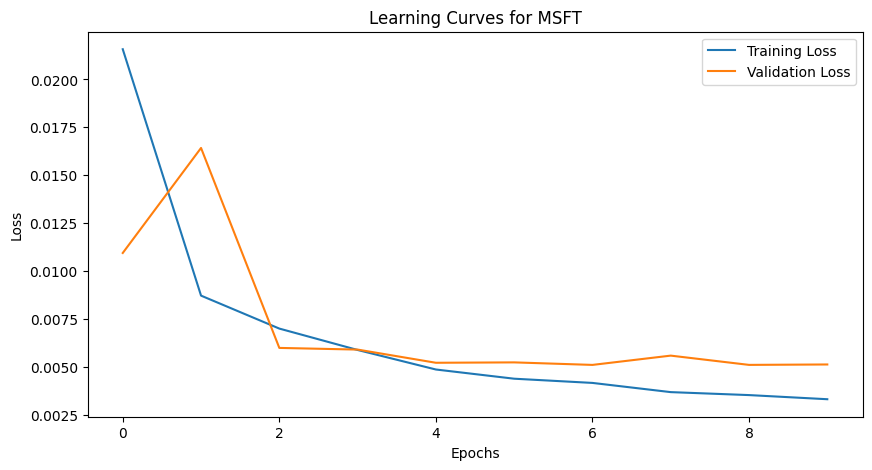

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['MSFT']

stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 5 Complete [00h 00m 17s]
val_mean_squared_error: 0.008228559046983719

Best val_mean_squared_error So Far: 0.006269491743296385
Total elapsed time: 00h 01m 31s
Epoch 1/10
71/71 [==============================] - 5s 27ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 3/10
71/71 [==============================] - 1s 20ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 6/10
71/71 [=============

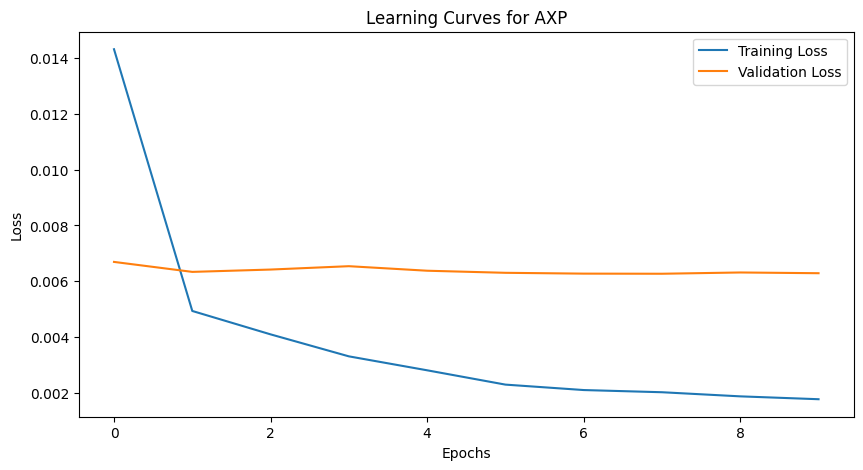

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['AXP']

stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 5 Complete [00h 00m 13s]
val_mean_squared_error: 0.007154189050197601

Best val_mean_squared_error So Far: 0.007154189050197601
Total elapsed time: 00h 01m 09s
Epoch 1/10
71/71 [==============================] - 5s 28ms/step - loss: 0.1357 - mean_squared_error: 0.1357 - val_loss: 0.0148 - val_mean_squared_error: 0.0148
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 5/10
71/71 [==============================] - 1s 10ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 6/10
71/71 [==============

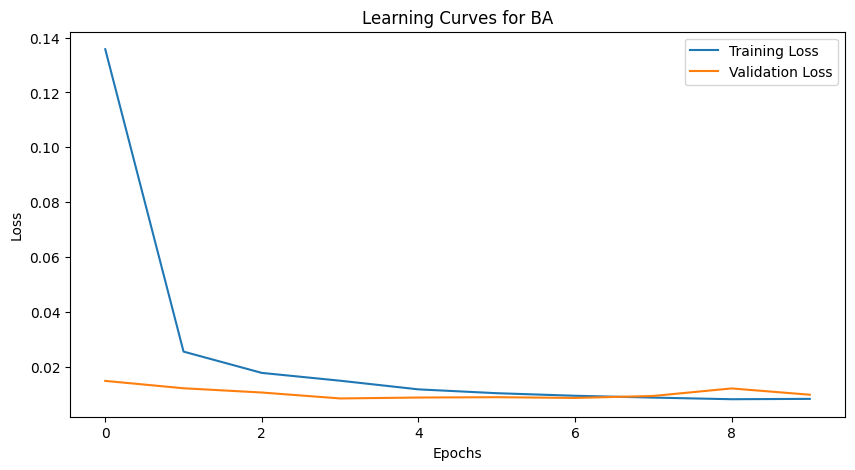

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['BA']

stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 5 Complete [00h 00m 15s]
val_mean_squared_error: 0.021837547421455383

Best val_mean_squared_error So Far: 0.007905990816652775
Total elapsed time: 00h 01m 12s
Epoch 1/10
71/71 [==============================] - 5s 30ms/step - loss: 0.0386 - mean_squared_error: 0.0386 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 2/10
71/71 [==============================] - 1s 14ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 3/10
71/71 [==============================] - 1s 12ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 6/10
71/71 [=============

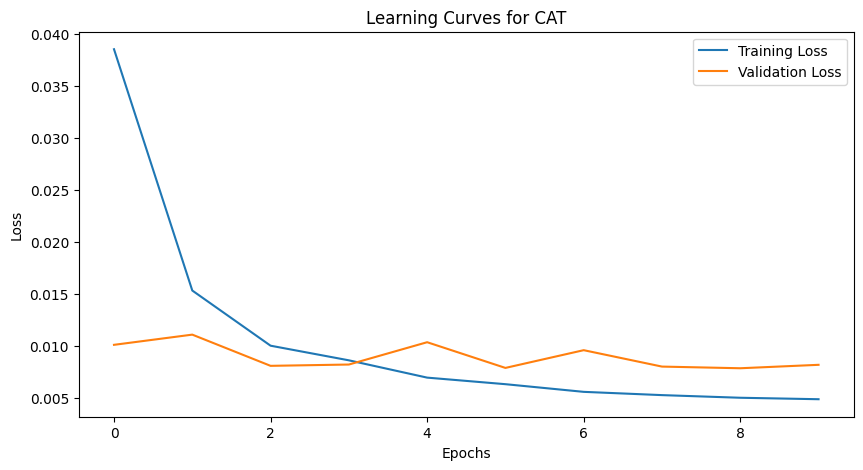

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['CAT']

stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 5 Complete [00h 00m 15s]
val_mean_squared_error: 0.004682570230215788

Best val_mean_squared_error So Far: 0.004111540503799915
Total elapsed time: 00h 01m 13s
Epoch 1/10
71/71 [==============================] - 4s 20ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 2/10
71/71 [==============================] - 1s 10ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 6/10
71/71 [==============

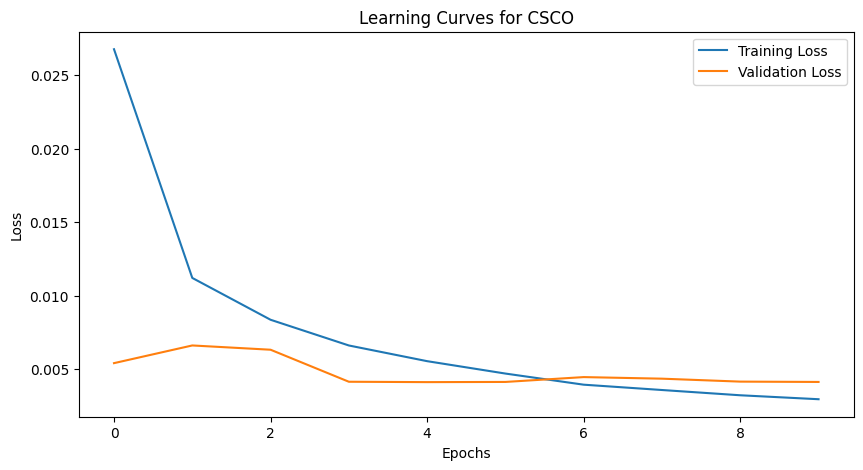

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['CSCO']

stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 5 Complete [00h 00m 27s]
val_mean_squared_error: 0.011494339443743229

Best val_mean_squared_error So Far: 0.0038953879848122597
Total elapsed time: 00h 01m 36s
Epoch 1/10
71/71 [==============================] - 9s 35ms/step - loss: 0.0186 - mean_squared_error: 0.0186 - val_loss: 0.0156 - val_mean_squared_error: 0.0156
Epoch 2/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 3/10
71/71 [==============================] - 1s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/10
71/71 [==============================] - 1s 14ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 5/10
71/71 [==============================] - 1s 14ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 6/10
71/71 [==========

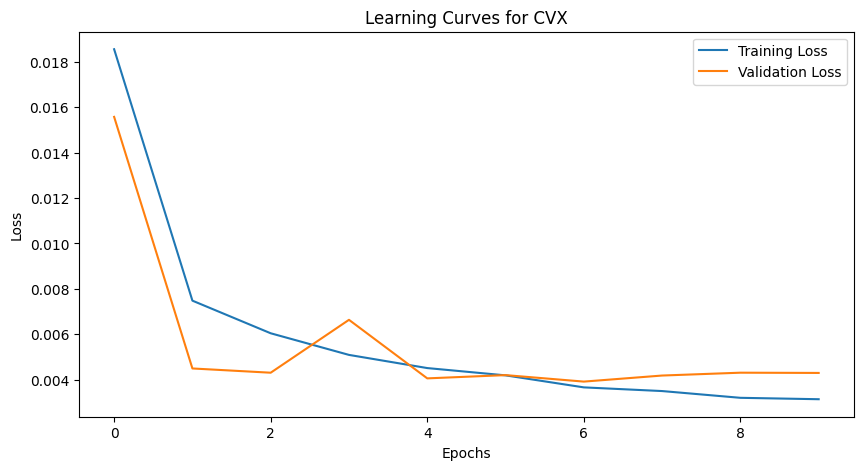

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['CVX']  # Chevron Corporation

stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 5 Complete [00h 00m 21s]
val_mean_squared_error: 0.007603393401950598

Best val_mean_squared_error So Far: 0.003651626640930772
Total elapsed time: 00h 01m 48s
Epoch 1/10
71/71 [==============================] - 9s 28ms/step - loss: 0.0294 - mean_squared_error: 0.0294 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 2/10
71/71 [==============================] - 2s 21ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 3/10
71/71 [==============================] - 1s 19ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 4/10
71/71 [==============================] - 1s 15ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/10
71/71 [==============================] - 1s 14ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/10
71/71 [===========

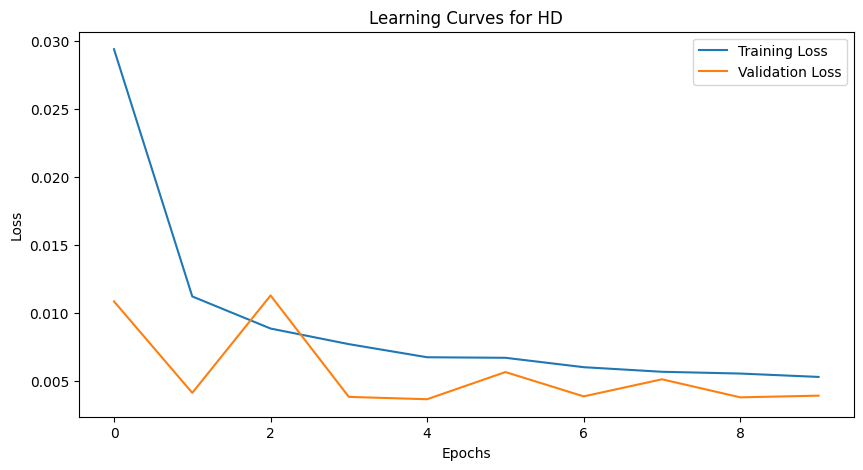

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['HD']   # The Home Depot, Inc.

stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 5 Complete [00h 00m 26s]
val_mean_squared_error: 0.01115337572991848

Best val_mean_squared_error So Far: 0.007408581208437681
Total elapsed time: 00h 01m 39s
Epoch 1/10
71/71 [==============================] - 7s 36ms/step - loss: 0.0623 - mean_squared_error: 0.0623 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 3/10
71/71 [==============================] - 1s 10ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 4/10
71/71 [==============================] - 1s 12ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 5/10
71/71 [==============================] - 1s 12ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 6/10
71/71 [=============

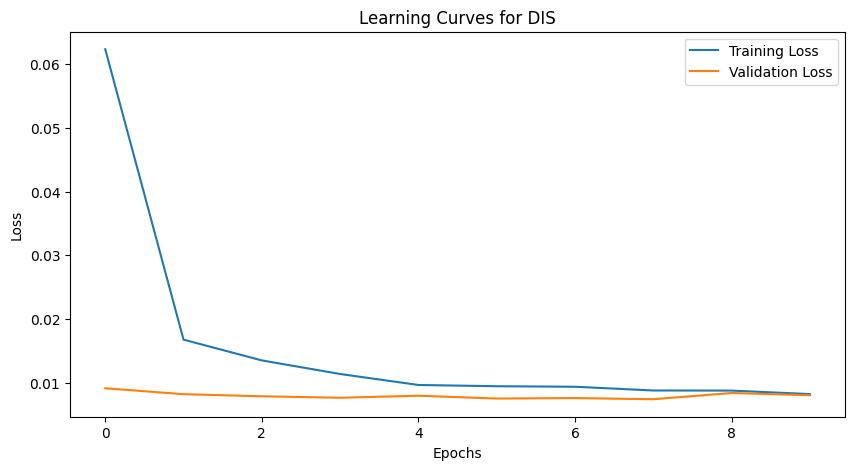

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['DIS']  # The Walt Disney Company

stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 5 Complete [00h 00m 13s]
val_mean_squared_error: 0.0067757205106318

Best val_mean_squared_error So Far: 0.0067757205106318
Total elapsed time: 00h 01m 15s
Epoch 1/10
71/71 [==============================] - 4s 21ms/step - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 5/10
71/71 [==============================] - 1s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 6/10
71/71 [==================

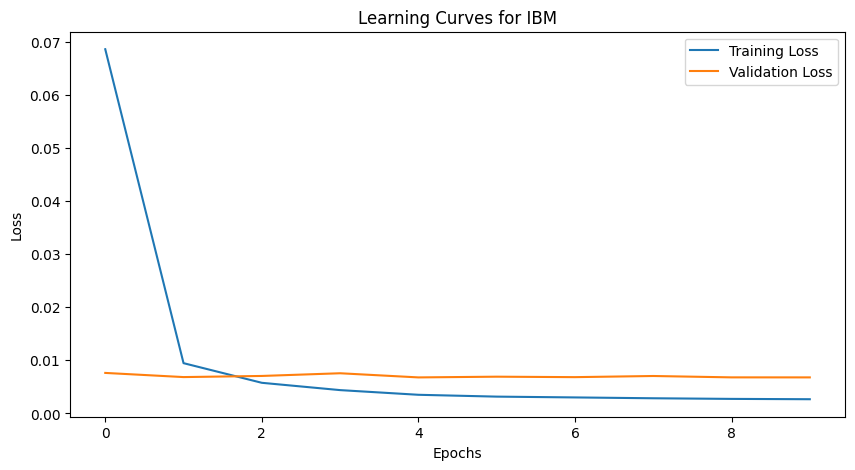

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['IBM']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 15s]
val_mean_squared_error: 0.013204392977058887

Best val_mean_squared_error So Far: 0.010249205864965916
Total elapsed time: 00h 01m 33s
Epoch 1/10
71/71 [==============================] - 4s 19ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 2/10
71/71 [==============================] - 1s 10ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 4/10
71/71 [==============================] - 1s 10ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0104 - val_mean_squared_error: 0.0104
Epoch 5/10
71/71 [==============================] - 1s 11ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 6/10
71/71 [============

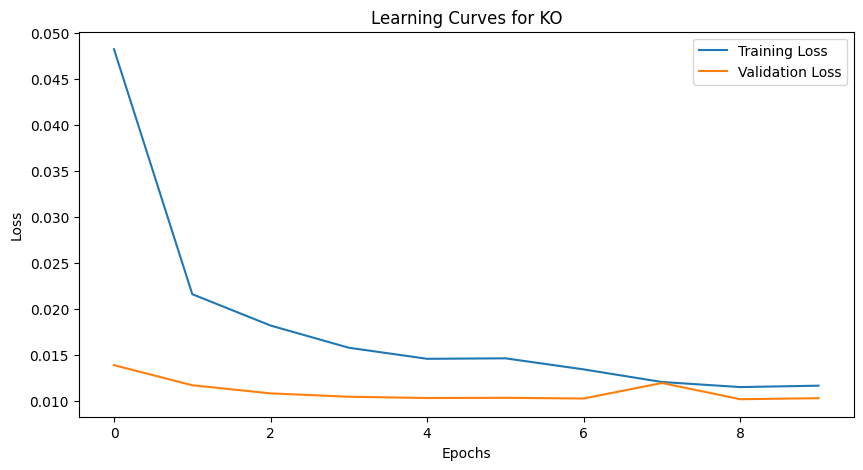

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['KO']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 15s]
val_mean_squared_error: 0.0060709379613399506

Best val_mean_squared_error So Far: 0.0060709379613399506
Total elapsed time: 00h 00m 44s
Epoch 1/10
71/71 [==============================] - 5s 26ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 2/10
71/71 [==============================] - 1s 10ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 4/10
71/71 [==============================] - 1s 10ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 6/10
71/71 [===========

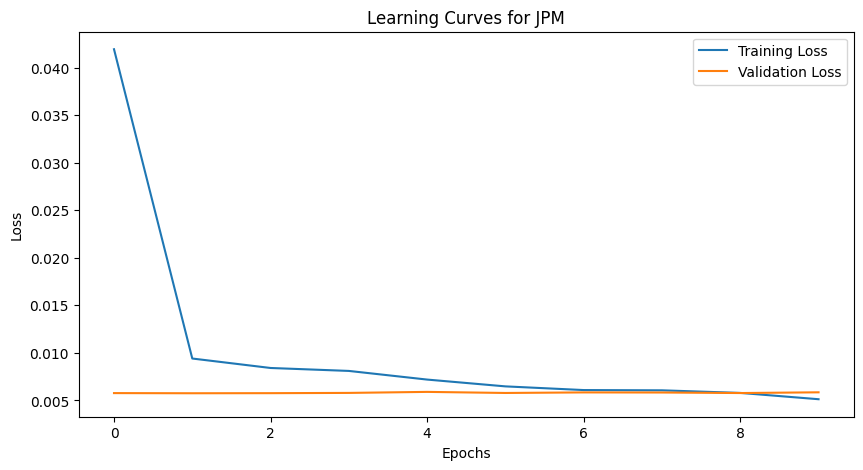

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['JPM']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 15s]
val_mean_squared_error: 0.007612871006131172

Best val_mean_squared_error So Far: 0.007612871006131172
Total elapsed time: 00h 00m 46s
Epoch 1/10
71/71 [==============================] - 4s 20ms/step - loss: 0.2875 - mean_squared_error: 0.2875 - val_loss: 0.2681 - val_mean_squared_error: 0.2681
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.1346 - mean_squared_error: 0.1346 - val_loss: 0.1238 - val_mean_squared_error: 0.1238
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0609 - val_mean_squared_error: 0.0609
Epoch 4/10
71/71 [==============================] - 1s 8ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 6/10
71/71 [===============

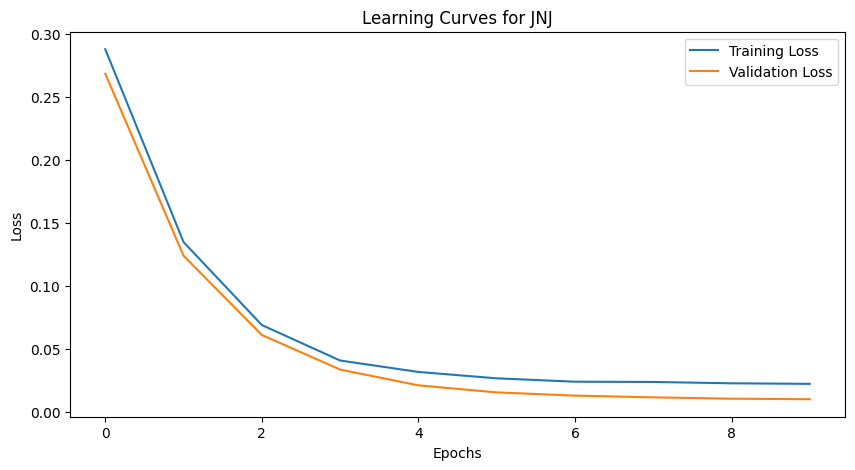

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['JNJ']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 14s]
val_mean_squared_error: 0.005065469071269035

Best val_mean_squared_error So Far: 0.005065469071269035
Total elapsed time: 00h 00m 46s
Epoch 1/10
71/71 [==============================] - 5s 20ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 6/10
71/71 [===============

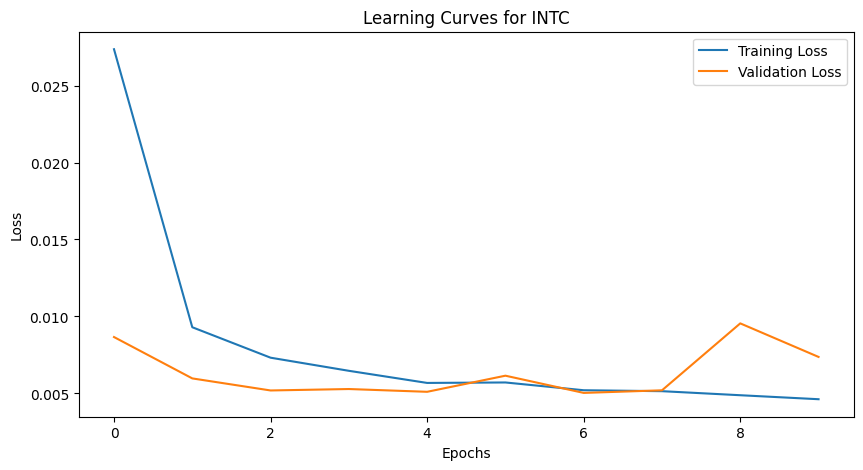

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['INTC']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 15s]
val_mean_squared_error: 0.006295354105532169

Best val_mean_squared_error So Far: 0.006284879520535469
Total elapsed time: 00h 00m 46s
Epoch 1/10
71/71 [==============================] - 5s 19ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 4/10
71/71 [==============================] - 1s 11ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 5/10
71/71 [==============================] - 1s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 6/10
71/71 [=============

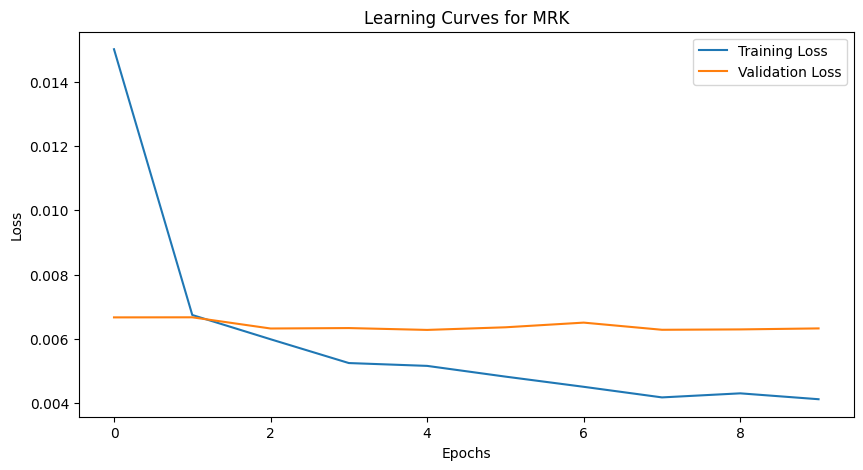

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['MRK']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 16s]
val_mean_squared_error: 0.14701911807060242

Best val_mean_squared_error So Far: 0.006505181547254324
Total elapsed time: 00h 00m 45s
Epoch 1/10
71/71 [==============================] - 5s 19ms/step - loss: 0.1737 - mean_squared_error: 0.1737 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0252 - mean_squared_error: 0.0252 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 6/10
71/71 [================

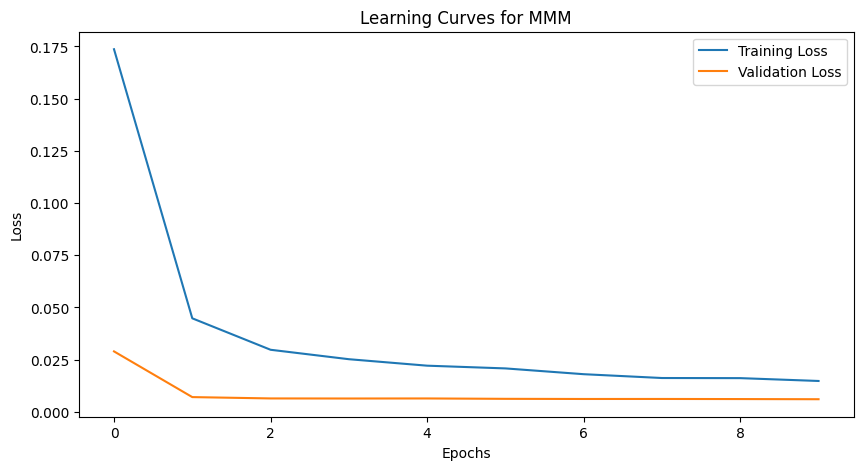

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['MMM']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 15s]
val_mean_squared_error: 0.0029368801042437553

Best val_mean_squared_error So Far: 0.0029368801042437553
Total elapsed time: 00h 00m 45s
Epoch 1/10
71/71 [==============================] - 5s 21ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 2/10
71/71 [==============================] - 1s 10ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 5/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 6/10
71/71 [===========

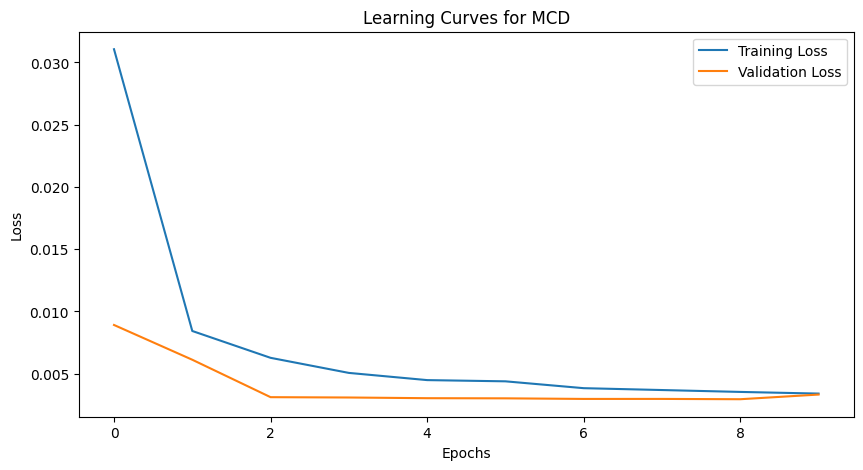

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['MCD']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 16s]
val_mean_squared_error: 0.008579663001000881

Best val_mean_squared_error So Far: 0.005921616684645414
Total elapsed time: 00h 00m 46s
Epoch 1/10
71/71 [==============================] - 5s 21ms/step - loss: 0.1049 - mean_squared_error: 0.1049 - val_loss: 0.0710 - val_mean_squared_error: 0.0710
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - val_loss: 0.0237 - val_mean_squared_error: 0.0237
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0125 - val_mean_squared_error: 0.0125
Epoch 4/10
71/71 [==============================] - 1s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0095 - val_mean_squared_error: 0.0095
Epoch 5/10
71/71 [==============================] - 1s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0084 - val_mean_squared_error: 0.0084
Epoch 6/10
71/71 [===============

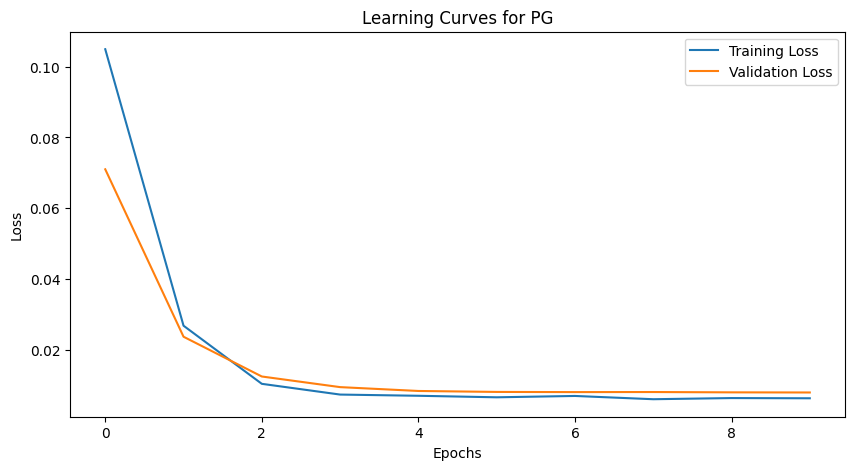

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['PG']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 16s]
val_mean_squared_error: 0.2571186125278473

Best val_mean_squared_error So Far: 0.005792777985334396
Total elapsed time: 00h 00m 47s
Epoch 1/10
71/71 [==============================] - 5s 27ms/step - loss: 0.3913 - mean_squared_error: 0.3913 - val_loss: 0.1735 - val_mean_squared_error: 0.1735
Epoch 2/10
71/71 [==============================] - 1s 13ms/step - loss: 0.1874 - mean_squared_error: 0.1874 - val_loss: 0.0221 - val_mean_squared_error: 0.0221
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0655 - mean_squared_error: 0.0655 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0161 - val_mean_squared_error: 0.0161
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 6/10
71/71 [================

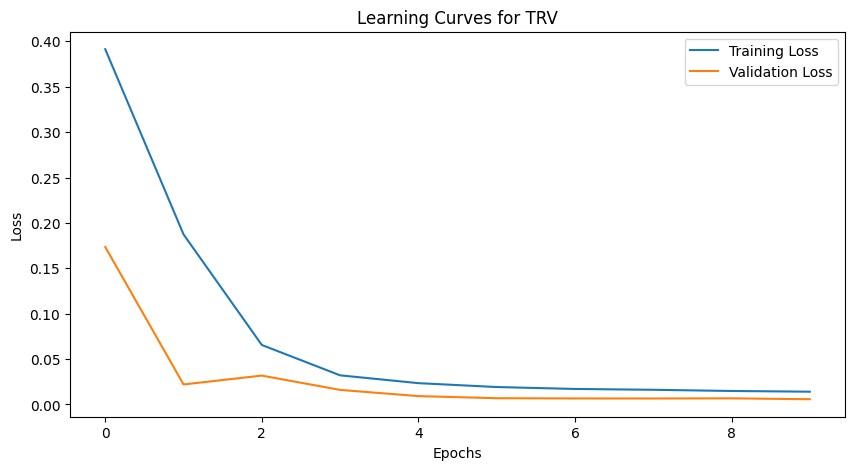

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['TRV']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 16s]
val_mean_squared_error: 0.016566989943385124

Best val_mean_squared_error So Far: 0.0056694019585847855
Total elapsed time: 00h 00m 48s
Epoch 1/10
71/71 [==============================] - 5s 20ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 4/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 6/10
71/71 [==============

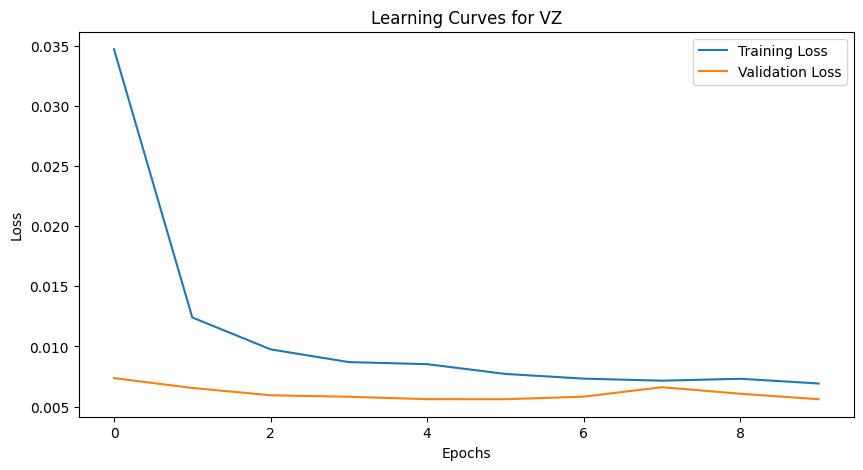

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['VZ']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

Trial 3 Complete [00h 00m 14s]
val_mean_squared_error: 0.004259594716131687

Best val_mean_squared_error So Far: 0.004259594716131687
Total elapsed time: 00h 00m 43s
Epoch 1/10
71/71 [==============================] - 5s 25ms/step - loss: 0.0248 - mean_squared_error: 0.0248 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 2/10
71/71 [==============================] - 1s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 3/10
71/71 [==============================] - 1s 12ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 4/10
71/71 [==============================] - 1s 12ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 5/10
71/71 [==============================] - 1s 9ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 6/10
71/71 [============

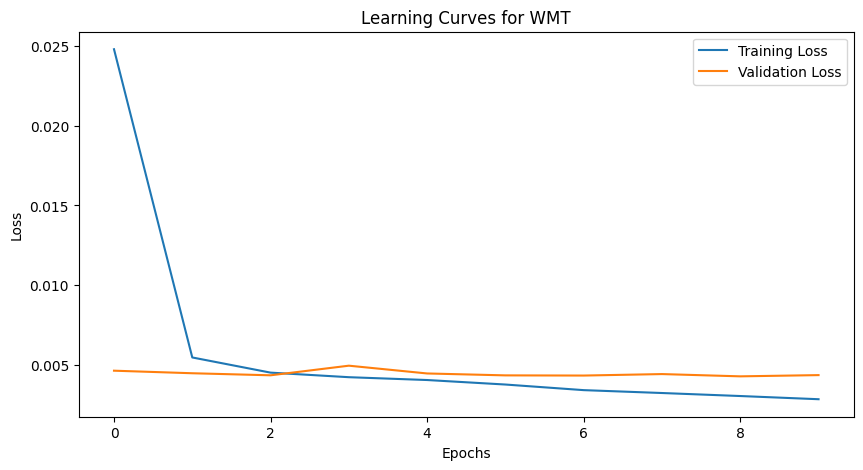

In [ ]:
# List of stock tickers and their DataFrames
stocks = ['WMT']  # International Business Machines Corporation


stock_dfs = {}

for stock in stocks:
    # Access the DataFrame for the current stock
    df = globals()[stock]
    stock_dfs[stock] = df

# Execute tuning for each stock
for stock in stocks:
    model, history = tune_model(stock, stock_dfs[stock])

**Data Preprocessing**
Feature Selection:

In both models, the selected input features are 'Adj Close', 'Volume', and 'RSI' (Relative Strength Index), which are common financial indicators used for stock price prediction.
The target feature for prediction is 'Log Returns', which is typically used to model the percentage change in stock prices and is more stable and normally distributed than raw prices.

**Normalization:**
A MinMaxScaler is applied to both the input features and the target variable. This scales the data to a range of [0, 1], which can improve the convergence speed during training and prevent issues related to numerical precision.
Normalization is crucial for LSTM and BiLSTM models because they are sensitive to the scale of the input data.

**Sequence Creation**
Sequence Preparation:
A sequence of 50 time steps is prepared for each sample. This means that for each prediction, the model will look at the 50 previous time points of data.
This step transforms the time series data into a supervised learning problem where the sequence of past observations is used to predict the next time step.

**Model Architecture**
Model Definition:

LSTM Model: A sequential model with LSTM layers that process the data in a forward direction, capturing temporal information from the past to the present.
BiLSTM Model: A sequential model with Bidirectional LSTM layers that process the data in both forward and backward directions, capturing temporal information from both past to present and future to past. This can potentially provide additional context and improve the model's accuracy.
Dropout:

Dropout layers with a rate of 0.3 are added to both models. Dropout is a regularization technique where randomly selected neurons are ignored during training, reducing the model's sensitivity to specific weights and helping to prevent overfitting.
Dense Output Layer:

Both models conclude with a Dense layer with a single unit, which is used to make the final prediction of the next time step's 'Log Returns'.
Model Compilation and Training
Compilation:

The Adam optimizer with a learning rate of 0.00001 is used to compile both models. Adam is an adaptive learning rate optimization algorithm that's well-suited for deep learning models.
The loss function is set as 'mean_squared_error', which is appropriate for regression problems.
Early Stopping:

An EarlyStopping callback is implemented with a patience of 5 epochs. This means that if the validation loss does not improve for five consecutive epochs, the training will stop early. This helps in avoiding overfitting and saves computational resources.
Training:

The models are trained for a maximum of 20 epochs with a batch size of 32. An epoch is one complete presentation of the data set to be learned to the learning machine. A batch size of 32 means that 32 samples from the dataset will be used to estimate the error gradient before the model weights are updated.

**Model Evaluation and Prediction**
Prediction and Inverse Scaling:

After training, the models are used to predict the 'Log Returns'. Because the data was normalized before training, an inverse transformation is applied to the predictions to convert them back to their original scale, allowing for a meaningful comparison with the actual 'Log Returns'.
Performance Metrics:

The Mean Squared Error (MSE) and the Root Mean Squared Error (RMSE) are calculated to evaluate the model's performance. These metrics provide a measure of how accurately the model predicts the target variable, with a lower value indicating a better fit.
Visualization:

The actual and predicted 'Log Returns' are plotted to visually assess how well the model's predictions align with the true values over time.
Differences Between LSTM and BiLSTM Implementation
While the overarching steps and structure of the model preparation, training, and evaluation are similar for LSTM and BiLSTM, the key difference lies in the directionality of the LSTM layers:

LSTM layers only capture information from past to present.
BiLSTM layers capture information from both past to present and future to past, providing the model with additional context that could lead to better performance, especially in cases where future time steps provide useful information for predicting the current step.

## Applying GARCH to estimate Co-Variance matrix for daily log-returns

In [ ]:
final_df = pd.DataFrame()

for stock in dji_stocks:
  df = globals()[stock]
  col_name = stock + "_log returns"
  final_df[col_name] = df['Log Returns']

final_df.tail()


,AXP_log returns,BA_log returns,CAT_log returns,CSCO_log returns,CVX_log returns,DIS_log returns,HD_log returns,IBM_log returns,INTC_log returns,JNJ_log returns,JPM_log returns,KO_log returns,MCD_log returns,MMM_log returns,MRK_log returns,MSFT_log returns,PG_log returns,TRV_log returns,VZ_log returns,WMT_log returns
Date,,,,,,,,,,,,,,,,,,,,
2024-04-17,-0.003073,-0.001996,-0.004344,-0.002716,0.000768,-0.008289,-0.005991,-0.003544,-0.016125,0.002213,-0.003990,0.007721,0.016886,-0.000989,0.002476,-0.006631,0.006456,-0.077022,0.000251,-0.003180
2024-04-18,-0.000781,0.000117,-0.001089,0.006674,0.007453,-0.004526,0.000180,-0.008942,-0.018100,0.006678,0.006476,0.006813,0.003808,0.005701,-0.001117,-0.018552,0.008536,0.018418,0.008760,-0.006560
2024-04-19,0.060392,-0.002411,-0.005539,0.004355,0.015304,0.001600,0.007392,0.000606,-0.024265,0.014780,0.024794,0.021163,0.003720,0.008599,0.004382,-0.012821,0.005390,0.017198,0.008931,0.004546
2024-04-22,0.008448,0.003879,0.008283,-0.003732,0.011929,-0.005521,0.002234,0.001761,0.006122,0.008147,0.019243,0.006296,0.013113,0.003786,0.009180,0.004600,0.015062,0.000934,-0.047803,0.010195
2024-04-23,0.025258,-0.007655,0.015648,0.003732,0.005727,0.015242,0.008562,0.001593,-0.003785,0.002946,0.014310,0.001485,0.004706,0.004094,-0.000473,0.016351,0.005962,0.000233,0.028099,-0.017613


In [ ]:
final_df = final_df.iloc[-int(len(final_df) * 0.2):, :]


In [ ]:
final_df = final_df.iloc[50:, :]


In [ ]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from arch import arch_model
import pickle
import warnings

warnings.filterwarnings("ignore")  # Suppress all warnings

last_valid_forecast = None  # Global variable to hold the last valid forecast

def garch_volatility_forecast(returns):
    global last_valid_forecast
    try:
        model = arch_model(returns, vol='Garch', p=1, q=1)
        model_fit = model.fit(disp='off', options={'maxiter': 500, 'ftol': 1e-07, 'disp': False})
        forecast = model_fit.forecast(horizon=1)
        next_day_vol = np.sqrt(forecast.variance.values[-1, :])
        last_valid_forecast = next_day_vol  # Update the last valid forecast
        return next_day_vol, model_fit
    except Exception as e:
        print(f"Model fitting failed: {e}")
        if last_valid_forecast is not None:
            return last_valid_forecast, None  # Return the last valid forecast if available
        else:
            # Return some default value, e.g., the mean of the returns if no valid forecasts have been made yet
            default_forecast = np.sqrt(np.var(returns))  # Use the sample variance as a naive forecast
            return default_forecast, None

def calculate_rolling_covariance(df, window_size=50):
    covariance_matrices = []
    metrics = []  # To store RMSE, MSE, AIC, BIC for each window
    print("Starting the rolling covariance calculation...")
    for end in range(window_size, len(df)):
        start = end - window_size
        print(f"Processing window from {start + 1} to {end}")
        window = df.iloc[start:end]
        volatilities = np.zeros(window.shape[1])  # Array to store volatilities for each stock
        fits = []

        # Process each stock's log-returns in the window
        for i, column in enumerate(window.columns):
            vol, fit = garch_volatility_forecast(window[column])
            volatilities[i] = vol
            fits.append(fit)

        # Metrics calculation
        if all(fit is not None for fit in fits):
            # Assuming returns are in the window and computing squared returns as a proxy for actual volatility
            actual_vol = np.square(window.iloc[-1])  # Placeholder for actual volatility proxy
            mse = np.mean((volatilities - np.sqrt(actual_vol))**2)
            rmse = np.sqrt(mse)
            aics = [fit.aic for fit in fits if fit is not None]
            bics = [fit.bic for fit in fits if fit is not None]
            avg_aic = np.mean(aics)
            avg_bic = np.mean(bics)
            metrics.append((rmse, mse, avg_aic, avg_bic))

        # Build the covariance matrix for this window
        correlation_matrix = window.corr()
        covariance_matrix = correlation_matrix.multiply(volatilities, axis='index').multiply(volatilities, axis='columns')
        covariance_matrices.append(covariance_matrix.values)

    # Convert list of covariance matrices into a 3D numpy array and pickle it
    covariance_matrices_np = np.array(covariance_matrices)
    with open('/content/drive/MyDrive/covariance_matrices.pkl', 'wb') as f:
        pickle.dump(covariance_matrices_np, f)

    if metrics:
        avg_metrics = np.mean(metrics, axis=0)  # Averages of RMSE, MSE, AIC, BIC
        print(f"Average RMSE: {avg_metrics[0]}")
        print(f"Average MSE: {avg_metrics[1]}")
        print(f"Average AIC: {avg_metrics[2]}")
        print(f"Average BIC: {avg_metrics[3]}")

    print("Completed the rolling covariance calculation.")
    return covariance_matrices_np, metrics

cov_matrices, garch_metrics = calculate_rolling_covariance(final_df)


## Optimizing portfolio using forecasted returns and covariance among stocks.

In [ ]:
import pandas as pd
import os

# Set the directory where your txt files are stored
directory = '/content/drive/MyDrive/'

# Initialize an empty DataFrame
log_returns_df = pd.DataFrame()

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('_predicted_returns.txt'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        # Read the numbers from the file into a DataFrame and then convert to Series if necessary
        temp_df = pd.read_csv(file_path, header=None, names=['returns'])
        # Get the stock ticker by splitting the filename
        stock_ticker = filename.split('_')[0]
        # Add this series as a new column to the DataFrame
        log_returns_df[stock_ticker] = temp_df['returns']

# Now `df` has each stock's log-returns as columns
log_returns_df.head()


,MSFT,AXP,BA,CAT,CSCO,CVX,HD,DIS,IBM,KO,JPM,JNJ,INTC,MRK,MMM,MCD,PG,TRV,VZ,WMT
0,-0.000219,-0.001845,0.010348,-0.005046,0.001350,0.011967,-0.009369,-0.013264,-0.000649,0.001939,-0.005429,-0.017207,-0.020286,0.001725,0.006479,-0.007606,-0.014099,-0.006851,0.000525,-0.001894
1,-0.000228,-0.001799,0.010659,-0.005056,0.001376,0.011635,-0.009259,-0.013140,-0.000652,0.002006,-0.005544,-0.017144,-0.020073,0.001739,0.006399,-0.007643,-0.013707,-0.008317,0.000555,-0.001874
2,-0.000225,-0.001774,0.010846,-0.005054,0.001392,0.011271,-0.009181,-0.013063,-0.000659,0.002105,-0.005652,-0.016997,-0.019891,0.001687,0.006332,-0.007712,-0.013287,-0.009592,0.000568,-0.001847
3,-0.000205,-0.001786,0.010833,-0.005060,0.001392,0.011122,-0.009120,-0.013025,-0.000666,0.002193,-0.005730,-0.016691,-0.019793,0.001637,0.006306,-0.007811,-0.012834,-0.010776,0.000545,-0.001768
4,-0.000259,-0.001833,0.010954,-0.005061,0.001374,0.010876,-0.009092,-0.012962,-0.000675,0.002262,-0.005813,-0.016111,-0.019736,0.001561,0.006286,-0.007920,-0.012307,-0.011829,0.000505,-0.001729


In [ ]:
# Replace 'your_file.pkl' with the path to your pickle file
file_path = '/content/drive/MyDrive/covariance_matrices.pkl'

# Open the pickle file and load the data
with open(file_path, 'rb') as file:
    covariance_matrix = pickle.load(file)

covariance_matrix = np.transpose(covariance_matrix, (1, 2, 0))
# Now `array` is your 3D NumPy array
print("Array shape:", covariance_matrix.shape)


Array shape: (20, 20, 667)


In [ ]:
!pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 706.3 kB/s eta 0:00:00


(20,)
Expected annual return: 1.4%
Annual volatility: 0.9%
Sharpe Ratio: 1.50
Optimized Weights: OrderedDict([('MSFT', 0.0), ('AXP', 0.0), ('BA', 0.0), ('CAT', 0.0), ('CSCO', 0.0), ('CVX', 0.5381), ('HD', 0.0), ('DIS', 0.0), ('IBM', 0.0), ('KO', 0.15207), ('JPM', 0.0), ('JNJ', 0.0), ('INTC', 0.0), ('MRK', 0.0), ('MMM', 0.0), ('MCD', 0.0), ('PG', 0.0), ('TRV', 0.30983), ('VZ', 0.0), ('WMT', 0.0)])
Expected annual return, annual volatility, Sharpe Ratio: (0.013962414060500021, 0.009293477782437635, 1.5023884908710403)


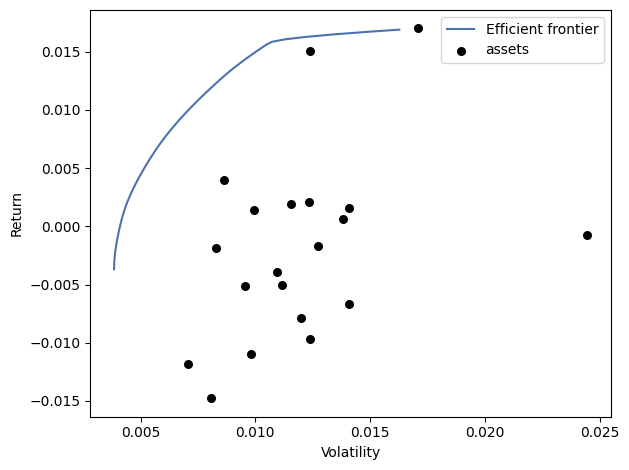

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

def optimize_portfolio(log_returns_df, covariance_matrices_np, time_step):
    """
    Optimize the portfolio to maximize the Sharpe ratio with a fallback to minimum volatility,
    and plot the efficient frontier.

    Parameters:
    - log_returns_df: DataFrame containing forecasted log returns of stocks.
    - covariance_matrices_np: 3D numpy array containing covariance matrices.
    - time_step: Index to select the specific covariance matrix.

    Returns:
    - cleaned_weights: Optimized weights for the portfolio.
    - performance: Tuple containing expected annual return, annual volatility, and Sharpe Ratio.
    """
    # Convert log returns to simple returns
    simple_returns = np.exp(log_returns_df) - 1
    mean_returns = simple_returns.mean()

    print(mean_returns.shape)

    # Get the covariance matrix for the specified time step
    latest_covariance_matrix = covariance_matrices_np[:, :, time_step]

    # Create the Efficient Frontier Object for optimization
    ef = EfficientFrontier(mean_returns, latest_covariance_matrix)

    # Maximize the Sharpe ratio, and get the raw weights
    # As the risk-free rate is not considered, use 0 for its approximation.
    try:
        raw_weights = ef.max_sharpe(risk_free_rate=0)
    except ValueError:
        print("No assets with expected returns exceeding zero. Falling back to minimum volatility portfolio.")
        raw_weights = ef.min_volatility()

    cleaned_weights = ef.clean_weights()  # Cleans small weights
    performance = ef.portfolio_performance(verbose=True)

    # Re-instantiate Efficient Frontier for plotting to avoid state issues
    ef_plot = EfficientFrontier(mean_returns, latest_covariance_matrix)

    # Plot the efficient frontier
    fig, ax = plt.subplots()
    plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

    return cleaned_weights, performance

# Example usage
# Assuming `log_returns_df` and `covariance_matrices_np` are defined and properly formatted
# Example DataFrame and 3D numpy array would be needed here.
cleaned_weights, performance = optimize_portfolio(log_returns_df, covariance_matrix, time_step=-1)
print("Optimized Weights:", cleaned_weights)
print("Expected annual return, annual volatility, Sharpe Ratio:", performance)


## Tradiutional Portfolio Optimization Methodlogy.

In [ ]:
org_log_returns = pd.DataFrame()

for stock in dji_stocks:
  temp_df = globals()[stock]
  col_name = stock + "_log returns"
  org_log_returns[col_name] = temp_df['Log Returns']

org_log_returns.head()

org_log_returns = org_log_returns.iloc[-int(len(org_log_returns) * 0.2):, :]


In [ ]:
def rolling_mean(df, window):
    return df.rolling(window=window).mean().iloc[window-1:]


In [ ]:
window_size = 50
rolling_avg = rolling_mean(org_log_returns, window_size)


In [ ]:
len(rolling_avg)

668

In [ ]:
import numpy as np
import pandas as pd

# Assuming 'org_log_returns' is already defined and contains your data

window_size = 50
n_periods = len(org_log_returns) - window_size + 1  # Calculate the number of windows

# Initialize a list to hold the covariance matrices
cov_matrices = []

# Loop through the DataFrame to compute the covariance matrix for each window
for i in range(n_periods):
    # Select the window slice
    window_data = org_log_returns.iloc[i:i + window_size]
    # Calculate the covariance matrix and append it to the list
    cov_matrix = window_data.cov()
    cov_matrices.append(cov_matrix.values)  # Store only the values (as a numpy array)

# Convert the list of matrices into a 3D numpy array
rolling_cov_matrices = np.array(cov_matrices)

print("Shape of the 3D numpy array:", rolling_cov_matrices.shape)


Shape of the 3D numpy array: (668, 20, 20)


Expected annual return: 0.1%
Annual volatility: 0.5%
Sharpe Ratio: 0.13


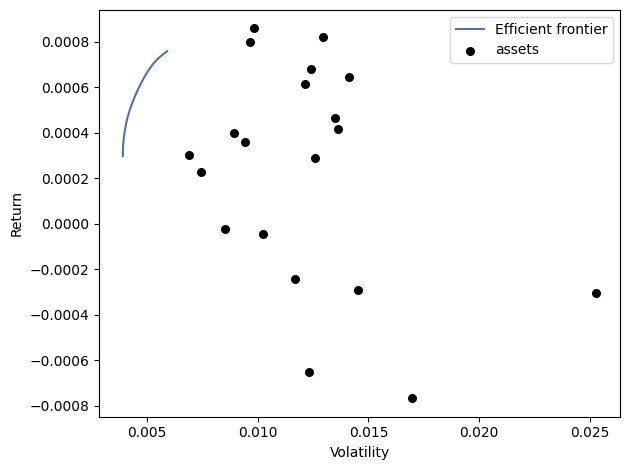

Optimized Weights: OrderedDict([(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.292), (5, 0.0), (6, 0.0), (7, 0.0983), (8, 0.0), (9, 0.0), (10, 0.0), (11, 0.0), (12, 0.00869), (13, 0.0), (14, 0.2456), (15, 0.11348), (16, 0.0), (17, 0.05528), (18, 0.0), (19, 0.18665)])
Expected annual return, annual volatility, Sharpe Ratio: (0.0006937888186243372, 0.005208220509273548, 0.13321033880746883)


In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

def optimize_portfolio(log_returns_df, covariance_matrices_np, time_step):
    # Convert log returns to simple returns
    simple_returns = np.exp(log_returns_df) - 1
    mean_returns = simple_returns.mean().values  # Ensure it's in the correct format (numpy array)

    # Get the covariance matrix for the specified time step
    latest_covariance_matrix = covariance_matrices_np[time_step]  # Correct index for the covariance matrix

    # Create the Efficient Frontier Object for optimization
    ef = EfficientFrontier(mean_returns, latest_covariance_matrix)

    # Maximize the Sharpe ratio, and get the raw weights
    # As the risk-free rate is not considered, use 0 for its approximation.
    try:
        raw_weights = ef.max_sharpe(risk_free_rate=0)
    except ValueError:
        print("No assets with expected returns exceeding zero. Falling back to minimum volatility portfolio.")
        raw_weights = ef.min_volatility()

    cleaned_weights = ef.clean_weights()  # Cleans small weights
    performance = ef.portfolio_performance(verbose=True)

    # Re-instantiate Efficient Frontier for plotting to avoid state issues
    ef_plot = EfficientFrontier(mean_returns, latest_covariance_matrix)

    # Plot the efficient frontier
    fig, ax = plt.subplots()
    plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)
    plt.show()

    return cleaned_weights, performance

# Example usage
cleaned_weights, performance = optimize_portfolio(rolling_avg, rolling_cov_matrices, time_step=-1)
print("Optimized Weights:", cleaned_weights)
print("Expected annual return, annual volatility, Sharpe Ratio:", performance)
